In [1]:
#%matplotlib widget

In [2]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_simple
import ariel_simple2
import ariel_gp
import ariel_load
import ariel_load_FGS
import ariel_load_AIRS
import ariel_pca
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import importlib
from tqdm import tqdm
import seaborn as sns
import pandas as pd
kgs.debugging_mode = 1
kgs.profiling=False
kgs.n_workers = 3

local


In [3]:
train_data = kgs.load_all_train_data()
train_data = train_data

In [4]:
importlib.reload(ariel_model)
import ariel_pca
importlib.reload(ariel_pca)
todo = dict()

baseline_model = ariel_model.baseline_model()

model=copy.deepcopy(baseline_model)
todo['Baseline'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.starter_model.model.supersample_factor = 5
# todo['Supersample factor 5'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.model_options.min_transit_scaling_factor /= 2
# todo['Min transit scaling d2'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.model_options.min_transit_scaling_factor *= 2
# todo['Min transit scaling *2'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.model_options.update_transit_variation_sigma = False # whether to update the magnitude of the transit depth variation; this effectively makes the fit less aggressive if the transit depth seems flat
# model.model.model.model_options.update_transit_pca_sigma = True
# model.model.model.model_options.update_transit_nonpca_sigma = True
# todo['Separate hyper tuning'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.model_options.n_samples_sigma_est  = model.model.model.model_options.n_samples_sigma_est//2
# todo['sigma est samples d2'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.starter_model.ok_threshold = 1.
# todo['OK threshold 1'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.starter_model.ok_threshold = 1.04
# todo['OK threshold 1.04'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.model_options.update_rate = 0.5
# model.model.model.model_options.n_iter = 12
# todo['Update rate 0.5 with 12 iters'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.starter_model.model.loaders[1].apply_full_sensor_corrections.pca_options.n_components = 3
# todo['n_comp 3 for background AIRS'] = model

# model=copy.deepcopy(baseline_model)
# model.model.model.starter_model.model.loaders[0].apply_time_binning.time_binning *= 2
# model.model.model.starter_model.model.loaders[1].apply_time_binning.time_binning *= 2
# todo['time binning *2'] = model

model=copy.deepcopy(baseline_model)
model.model.model.starter_model.model.loaders[0].apply_pixel_corrections.mask_hot = not model.model.model.starter_model.model.loaders[0].apply_pixel_corrections.mask_hot
model.model.model.starter_model.model.loaders[1].apply_pixel_corrections.mask_hot = not model.model.model.starter_model.model.loaders[1].apply_pixel_corrections.mask_hot
todo['mask_hot swap'] = model

model=copy.deepcopy(baseline_model)
model.model.model.starter_model.model.loaders[0].apply_pixel_corrections.mask_hot = not model.model.model.starter_model.model.loaders[0].apply_pixel_corrections.mask_hot
model.model.model.starter_model.model.loaders[1].apply_pixel_corrections.mask_hot = not model.model.model.starter_model.model.loaders[1].apply_pixel_corrections.mask_hot
model.model.model.starter_model.chop_threshold = np.inf
model.model.model.model_options.update_transit_variation_sigma = False # whether to update the magnitude of the transit depth variation; this effectively makes the fit less aggressive if the transit depth seems flat
model.model.model.model_options.update_transit_pca_sigma = True
model.model.model.model_options.update_transit_nonpca_sigma = True
todo['mask_hot swap, separate tuning, no chop'] = model

In [5]:

kgs.sanity_checks_active = False
print('Sanity checks off!')
def fname(k):
    return kgs.temp_dir + 'evaluate_model_'+k+'__'+str(len(train_data))+'.pickle'
for k,v in todo.items():
    if not os.path.isfile(fname(k)):
        print(k)
        model = copy.deepcopy(v)
        model.model.model.run_in_parallel = True
       # model.model.run_in_parallel = False
#         print('!!! also loader')
        #if k=='Run on new simple reg kepler fudge_var adjust_u':
            
        #model_ref = kgs.dill_load(fname('All + multifudge'))[2]
        #model._cached_planet_id = model_ref._cached_planet_id
        #model._cached_result = model_ref._cached_result
            # model.bias_a = model_ref.bias_a
            # model.bias_b = model_ref.bias_b
            # model.sigma_fudge_FGS = model_ref.sigma_fudge[0]
            # model.sigma_fudge_AIRS_mean = model_ref.sigma_fudge[1]
            # model.sigma_fudge_AIRS_var = model_ref.sigma_fudge[1]
        
        # Precache data
        #print('precache off')
        for d in tqdm(train_data):
            copy.deepcopy(d).load_to_step(5,model.model.model.starter_model.model.loaders)
        
        
        
        #model.state=1
        model.train(train_data)
        #kgs.list_attrs(model)
        inferred_data = model.infer(train_data)
        print(k)
        print(kgs.score_metric(inferred_data, train_data))
        #print('not saving')
        #kgs.list_attrs(model)
        #if k=='Baseline':
        kgs.dill_save(fname(k), (inferred_data,train_data,model,kgs.git_commit_id))
        #print(inferred_data[0].spectrum[0], inferred_data[0].spectrum_cov[0,0])
        #print(inferred_data[-1].spectrum[0], inferred_data[-1].spectrum_cov[0,0])
    else:
        print(k)
        (inferred_data,train_data_here,model,_) = kgs.dill_load(fname(k))
        #print(model.model.model_options.FGS_order)
        print(kgs.score_metric(inferred_data, train_data_here))

Sanity checks off!
Baseline
Score:           0.6526
RMS error FGS:   177.11037 ppm
mRMS error FGS:  47.14551 ppm
RMS error AIRS:  142.11124 ppm
mRMS error AIRS: 42.45224 ppm
RMS error AIRSv: 55.95599 ppm
mRMS error AIRSv:26.68991 ppm
(0.6525501552765501, 0.00017711037120594003, 0.00014211124092932588)
mask_hot swap
Score:           0.6525
RMS error FGS:   177.88885 ppm
mRMS error FGS:  46.81379 ppm
RMS error AIRS:  142.37601 ppm
mRMS error AIRS: 42.58386 ppm
RMS error AIRSv: 55.98977 ppm
mRMS error AIRSv:26.70329 ppm
(0.6525112169848675, 0.00017788885235574874, 0.00014237601332280417)
mask_hot swap, separate tuning, no chop


Processing in parallel: 100%|█████████████████████████████████████████████████████| 1099/1099 [1:40:37<00:00,  5.49s/it]


local
SpawnPoolWorker-2 2
CUDA_VISIBLE_DEVICES= 0
New solver/alternative transit parameters fallback for planet id 450197552
New solver/alternative transit parameters fallback for planet id 824937040
New solver/alternative transit parameters fallback for planet id 905997089
New solver/alternative transit parameters fallback for planet id 1267583899
New solver/alternative transit parameters fallback for planet id 1293223638
New solver/alternative transit parameters fallback for planet id 1329906799
New solver/alternative transit parameters fallback for planet id 1547333761
New solver/alternative transit parameters fallback for planet id 1648240892
New solver/alternative transit parameters fallback for planet id 1748544529
New solver/alternative transit parameters fallback for planet id 2101537217
New solver/alternative transit parameters fallback for planet id 2364471819
New solver/alternative transit parameters fallback for planet id 3050552096
New solver/alternative transit parameters

In [6]:
%matplotlib widget
ignore_bad_planets = False
def filter_bad_data(data):
    data_out = []
    for d in data:
        if not d.planet_id in [1349926825, 3786449677, 2554492145, 1267010874, 94572221, 2270815333, 3649218579, 576917580, 2154305089, 2207815333, 2740910036]:
            data_out.append(d)
    return data_out
        
def basics():
    plt.grid(True)
    plt.box(True)
def plot_two_sensors(func, xl, yl, mod):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0]);basics()
    plt.title('FGS')
    plt.xlabel(xl)
    plt.ylabel(yl)
    sc=func(slice(0,1), 'blue', 'FGS')
    mod()
    kgs.add_cursor(sc)
    
    plt.sca(ax[1]);basics()
    plt.title('AIRS')
    plt.xlabel(xl)
    sc=func(slice(1,283), 'red', 'AIRS')
    mod()
    kgs.add_cursor(sc)
    
    plt.pause(0.001)

def report_extreme_ratios(x,y,name):
    return    
    print(name)
    inds = np.argsort(np.abs(y/x))[::-1]
    for ii in inds[:2]:
        print(f'{inferred_data[ii].planet_id}, ratio:{np.abs(y[ii]/x[ii]):.3f}, x:{x[ii]:.3e}, y:{y[ii]:.3e}, RMS:{kgs.rms(error_matrix[ii,:]):.3e}')
    
    
fname_list = [fname(k) for k in todo.keys()]
#fname_list = ['evaluate_model_Baseline__989.pickle', 'evaluate_model_Baseline__110.pickle', 'evaluate_model_Multi-transit__110.pickle']
for f in fname_list:
    (inferred_data,train_data_here,model,_) = kgs.dill_load(f)
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
        train_data_here = filter_bad_data(train_data_here)
    else:
        train_data_here = train_data_here
    #model.bias_a[0]+=0.006
    #model.bias_a[1]-=0.0002
    #inferred_data = model.infer(train_data)
    
    
    print(f)
    print(model.bias_a)
    print(model.bias_b)
    print(model.sigma_offset)
    print(model.sigma_fudge_FGS, model.sigma_fudge_AIRS_mean, model.sigma_fudge_AIRS_var)
    print('mul', model.sigma_fudge_multi)
    
    print(kgs.score_metric(inferred_data, train_data_here,print_results=True))
    print('')
    
    continue
    
    
    
    
    #try:
    #    print(model.sigma_offset)
    #except: pass
    #print(model.sigma_fudge)    
    #kgs.list_attrs(model)
    #kgs.score_metric(inferred_data, train_data_here)
    print('')
    #print('3')
    #kgs.score_metric(inferred_data[:3], train_data_here[:3]) 
    #print('')
    # print('No fudge')
    # #model.sigma_fudge = [1,1]
    # #try: model.sigma_offset = [0,0]
    # #except: pass
    # #model.bias_a = [1,1]
    # #model.bias_b = [0,0]
    # # print('!!!')
    # model.sigma_offset = [0,0]
    # model.sigma_fudge_FGS = 1.
    # model.sigma_fudge_AIRS_mean = 1.
    # model.sigma_fudge_AIRS_var = 1.
    # inferred_data = model.infer(train_data_here)
    #if ignore_bad_planets:
    #    inferred_data = filter_bad_data(inferred_data)
    #kgs.score_metric(inferred_data, train_data_here)     
    error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data_here)])
    true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data_here)])
    
    T1 = []
    T4 = []
    for d in inferred_data:
        trans = d.diagnostics['transit_params_gp'][1]
        trans.Rp = ariel_gp.msqrtabs(-np.mean(d.spectrum))
        times = np.linspace(-3,10,10000)
        light_curve = trans.light_curve(times)
        assert(light_curve[0]==1)
        assert(light_curve[1]==1)
        T1.append(times[np.argwhere(light_curve!=1)[0][0]])
        T4.append(times[np.argwhere(light_curve!=1)[-1][0]])
    T1 = np.array(T1)
    T4 = np.array(T4)
        
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = T1
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'T1 [h]', 'Prediction error / sigma (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = T4
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'T4 [h]', 'Prediction error / sigma (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.argsort(np.argsort(T4-T1))
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'T4-T1 rank', 'Prediction error / sigma (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = T4-T1
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'T4-T1 [h]', 'Prediction error / sigma (mean)', lambda:0)
    
#    continue
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.transit_params.Rs for d in train_data_here]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'Rs', 'Prediction error / sigma (mean)', lambda:0)
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.transit_params.Ts for d in train_data_here]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'Ts', 'Prediction error / sigma (mean)', lambda:0)
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.transit_params.Mp for d in train_data_here]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'Mp', 'Prediction error / sigma (mean)', lambda:0)
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.transit_params.Ms for d in train_data_here]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'Ms', 'Prediction error / sigma (mean)', lambda:0)
    
 #   continue
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [len(d.transits) for d in inferred_data]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'Number of transits', 'Prediction error / sigma (mean)', lambda:0)
    
    #conintue
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
        return sc
        
    plot_two_sensors(plot_prediction_vs_true, 'True value (mean)', 'Prediction error (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
        return(sc)
    def mod():
        plt.axline((0,0), slope=3, color='black')
        plt.axline((0,0), slope=-3, color = 'black')        
    plot_two_sensors(plot_mean_error_vs_sigma, 'Sigma prediction (mean)', 'Prediction error (mean)', mod)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.std(true_matrix[:,1:],1)
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (mean)', lambda:0)
    

    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS residual ratio', 'Prediction error / sigma (mean)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
#         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#         #y = np.mean(error_matrix[:,slic],1)
#         sc=plt.scatter(x,y,color = col)
#         #print(y[934])
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'FGS residual ratio', 'Prediction error / sigma (mean)', lambda:0)
    
    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel('Sigma prediction')
    plt.ylabel('STD error')
    n=282
    x=np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
    y=np.sqrt(np.var(error_matrix[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    report_extreme_ratios(x,y,'AIRS variation')    
    plt.pause(0.001)
    
    continue
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.mean(true_matrix[:,slic],1)
#         y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
#         plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#     plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
#     def plot_mean_error_vs_sigma(slic,col, name):
#         x = np.std(true_matrix[:,1:],1)
#         y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
#         sc=plt.scatter(x,y,color = col)
#         report_extreme_ratios(x,y,name)    
#         return sc
#     plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
    
    
#     for ii in range(len(inferred_data[0].diagnostics['transit_params_gp_par'])):
#         def plot_mean_error_vs_sigma(slic,col, name):
#             x = [d.diagnostics['transit_params_gp_par'][ii] for d in inferred_data]
#             y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
#             #y = np.mean(error_matrix[:,slic],1)
#             sc=plt.scatter(x,y,color = col)
#             #print(y[934])
#             report_extreme_ratios(x,y,name)    
#             return sc
#         plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param {ii}', 'Prediction error / sigma (mean)', lambda:0)
    
    
    
    # for ii in range(7):
    #     if ii==4:
    #         continue
    #     def plot_mean_error_vs_sigma(slic,col, name):
    #         x = [d.diagnostics['transit_params_gp'][0].to_x()[ii] for d in inferred_data]
    #         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
    #         #y = np.mean(error_matrix[:,slic],1)
    #         sc=plt.scatter(x,y,color = col)
    #         #print(y[934])
    #         report_extreme_ratios(x,y,name)    
    #         return sc
    #     plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param FGS {ii}', 'Prediction error / sigma (mean)', lambda:0)
        
    # for ii in np.arange(5,7):
    #     def plot_mean_error_vs_sigma(slic,col, name):
    #         x = [d.diagnostics['transit_params_gp'][1].to_x()[ii] for d in inferred_data]
    #         y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
    #         #y = np.mean(error_matrix[:,slic],1)
    #         sc=plt.scatter(x,y,color = col)
    #         #print(y[934])
    #         report_extreme_ratios(x,y,name)    
    #         return sc
    #     plot_two_sensors(plot_mean_error_vs_sigma, f'Transit param AIRS {ii}', 'Prediction error / sigma (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [d.diagnostics['transit_params_gp'][1].t0-d.diagnostics['transit_params_gp'][0].t0 for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #print(y[934])
        report_extreme_ratios(x,y,name)    
        return sc
    plot_two_sensors(plot_mean_error_vs_sigma, f't0 diff', 'Prediction error / sigma (mean)', lambda:0)
    
    mat = np.stack([d.diagnostics['transit_params_gp_par'] for d in inferred_data])[:,:,0]
    mat.shape
    
    plt.figure()
    plt.imshow(np.corrcoef(mat.T))
    plt.colorbar()
    sns.pairplot(pd.DataFrame(mat), diag_kind="hist", corner=True, height=1.5)
    
    for ii in range(inferred_data[0].diagnostics['transit_params_gp_par_cov'].shape[0]):
        plt.figure()
        plt.plot( np.sqrt([d.diagnostics['transit_params_gp_par_cov'][ii,ii] for d in inferred_data]))
        plt.title(ii-1)
        #plt.plot( np.sqrt([d.diagnostics['transit_params_gp_par_cov'][6,6] for d in inferred_data]))
    for ii in range(2):
        for jj in range(7):
            if jj==4:
                continue
            x = [d.diagnostics['transit_params'][ii].to_x()[jj] for d in inferred_data]
            y = [d.diagnostics['transit_params_gp'][ii].to_x()[jj] for d in inferred_data]
            plt.figure()
            plt.scatter(x,y)
            plt.title(str(ii) + ' ' + str(jj))
            plt.xlabel('Simple')
            plt.ylabel('GP')
            plt.axline((x[0],x[0]), slope=1, color='black')

/mnt/d//ariel2/temp/evaluate_model_Baseline__1099.pickle
[1.0000389234765845, 0.9992683696884602]
[6.763030441687455e-05, 0.00017383451557695525]
[8.682985568691014e-08, -1.0323619352500136e-08]
2.0274381655617586 2.05228434899402 1.0017900595183522
mul 1.0
Score:           0.6526
RMS error FGS:   177.11037 ppm
mRMS error FGS:  47.14551 ppm
RMS error AIRS:  142.11124 ppm
mRMS error AIRS: 42.45224 ppm
RMS error AIRSv: 55.95599 ppm
mRMS error AIRSv:26.68991 ppm
(0.6525501552765501, 0.00017711037120594003, 0.00014211124092932588)

/mnt/d//ariel2/temp/evaluate_model_mask_hot swap__1099.pickle
[1.0000518167524854, 0.9992626353128752]
[6.778908896378827e-05, 0.00017480081879164613]
[-4.378849108579168e-09, -1.0763335157961273e-08]
2.0379896651270606 2.0482320028621874 0.9999504717825097
mul 1.0
Score:           0.6525
RMS error FGS:   177.88885 ppm
mRMS error FGS:  46.81379 ppm
RMS error AIRS:  142.37601 ppm
mRMS error AIRS: 42.58386 ppm
RMS error AIRSv: 55.98977 ppm
mRMS error AIRSv:26.7032

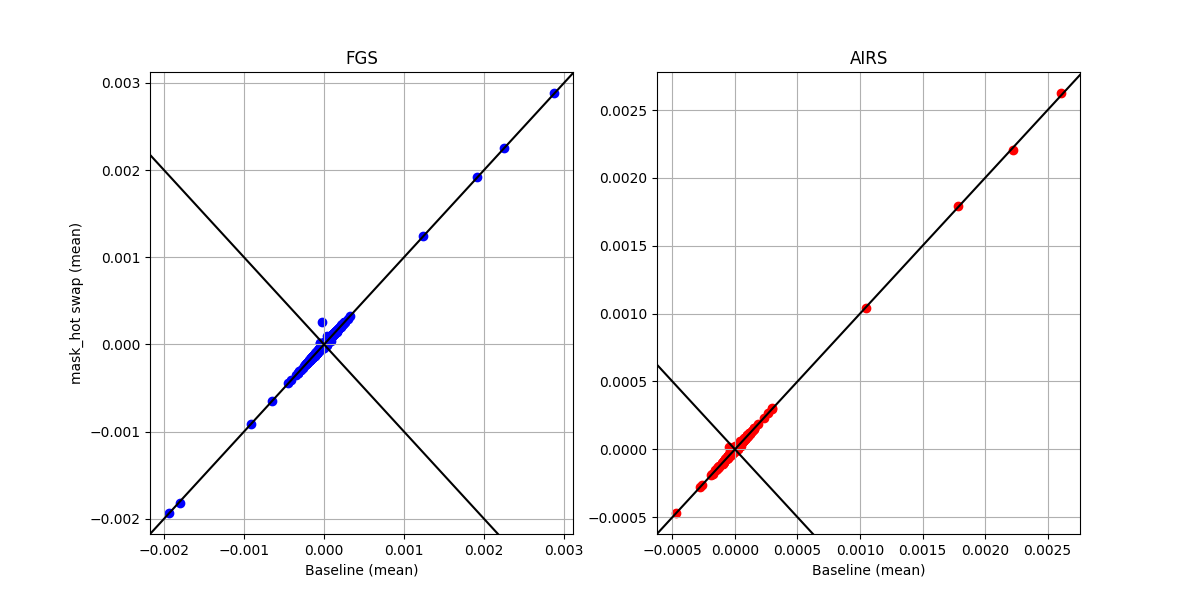

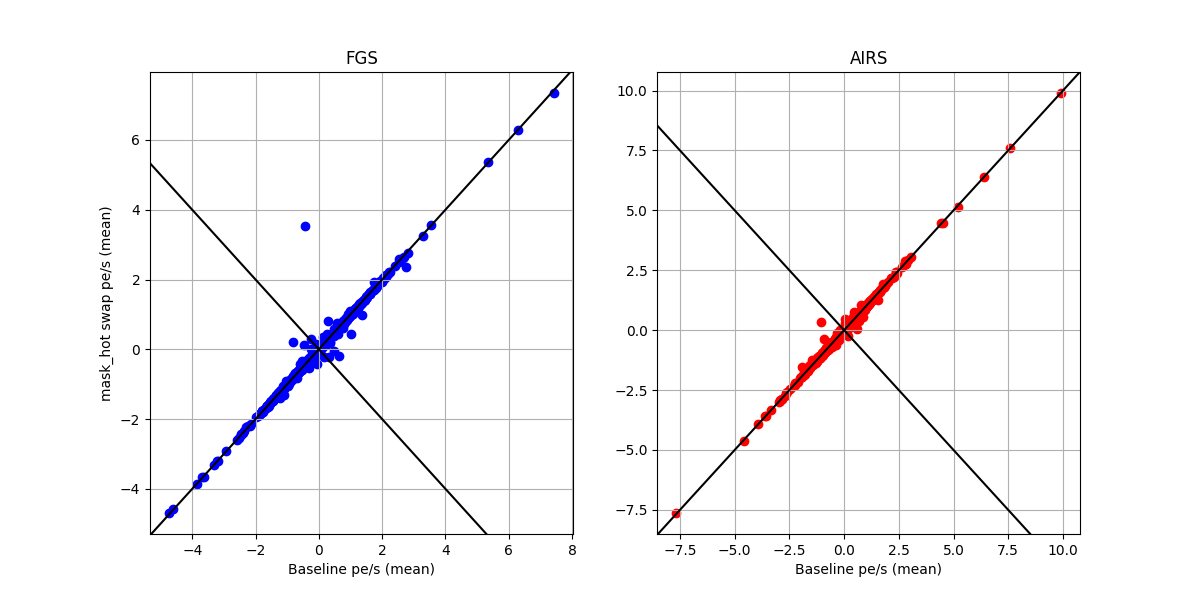

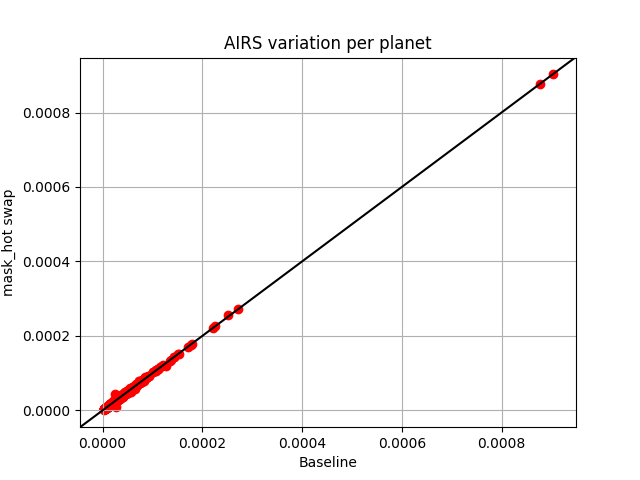

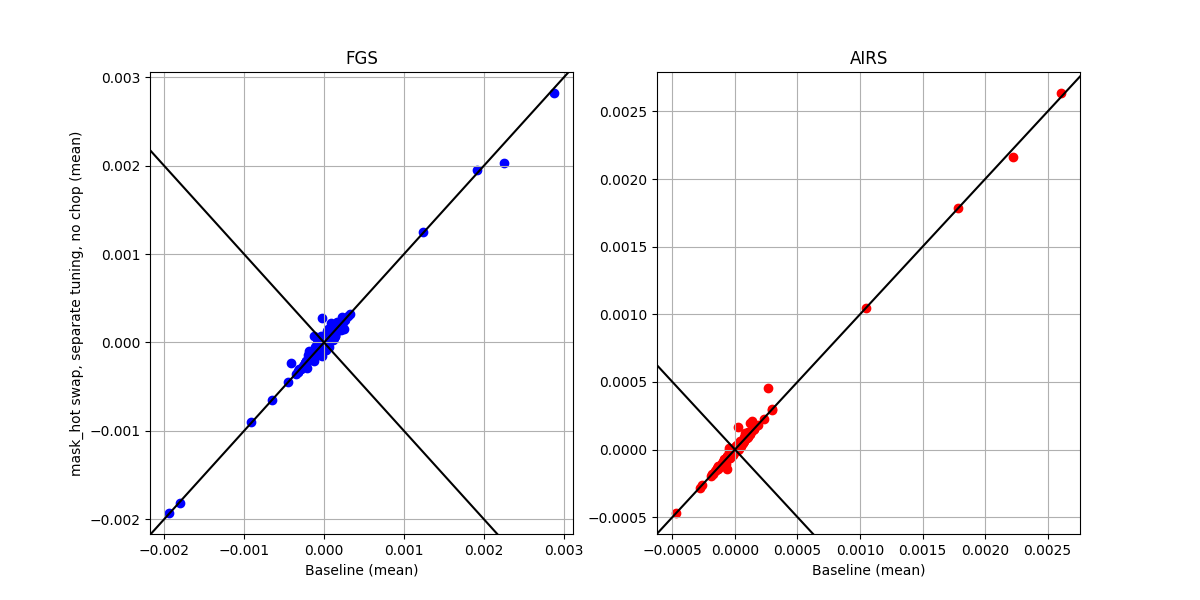

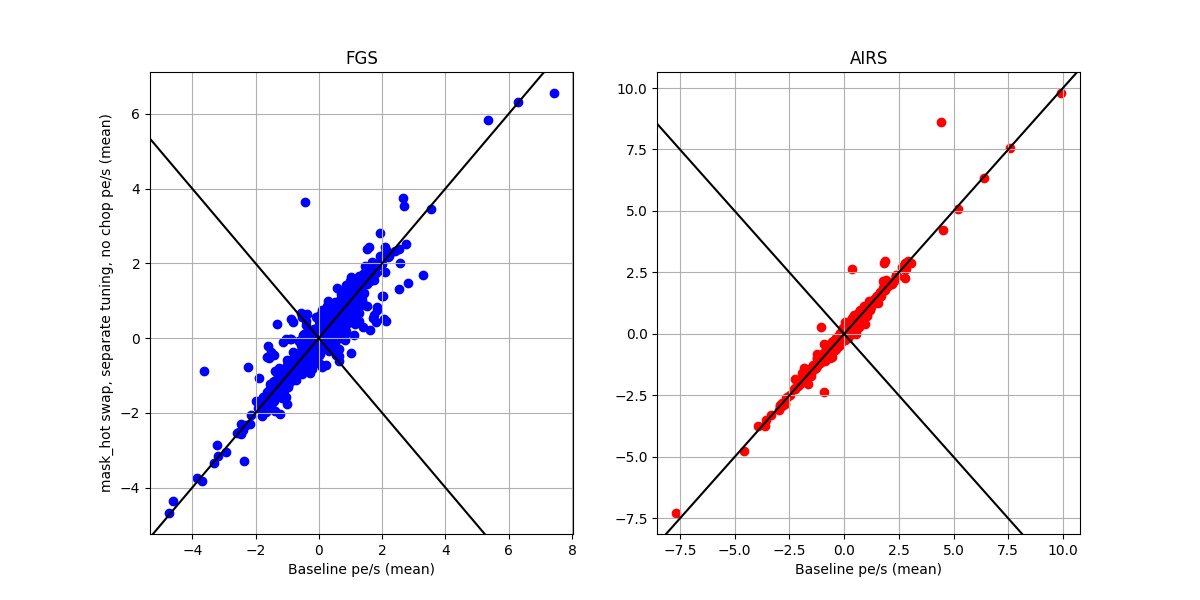

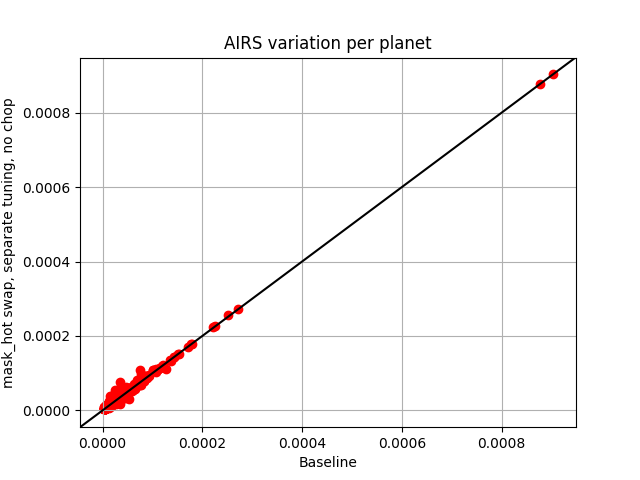

In [7]:
compare1= list(todo.keys())[0]
data1 = kgs.dill_load(fname(compare1))[0]
if ignore_bad_planets:
    data1 = filter_bad_data(data1)
for k,v in todo.items():    
    compare2= k
    if compare2==compare1:
        continue    
    data2 = kgs.dill_load(fname(compare2))[0]
    if ignore_bad_planets:
        data2 = filter_bad_data(data2)
        train_data_here = filter_bad_data(train_data)
    else:
        train_data_here = train_data           
    error1 = np.array([d.spectrum - t.spectrum for d,t in zip(data1,train_data_here)])
    error2 = np.array([d.spectrum - t.spectrum for d,t in zip(data2,train_data_here)])
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)
        y = np.mean(error2[:,slic],1)
        sc=plt.scatter(x,y,color = col)
        #kgs.add_cursor(sc)
        return sc

    plot_two_sensors(plot_prediction_vs_true, compare1+' (mean)', compare2+' (mean)', lambda:(plt.axline((0,0),slope=1,color='black'),plt.axline((0,0),slope=-1,color='black')))
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)/np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in data1])
        y = np.mean(error2[:,slic],1)/np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in data2])
        #print(x[934],y[934])
        sc=plt.scatter(x,y,color = col)
        return sc
        #kgs.add_cursor(sc)
    plot_two_sensors(plot_prediction_vs_true, compare1+' pe/s (mean)', compare2+' pe/s (mean)', lambda:(plt.axline((0,0),slope=1,color='black'),plt.axline((0,0),slope=-1,color='black')))
    
#     continue
    
#     for ii in range(2):
#         for jj in range(7):
#             if jj==4:
#                 continue
#             # x = [d.diagnostics['transit_params'][ii].to_x()[jj] for d in data1]
#             # y = [d.diagnostics['transit_params'][ii].to_x()[jj] for d in data2]
#             # plt.figure()
#             # sc=plt.scatter(x,y)
#             # plt.axline((x[0],x[0]), slope=1, color='black')
#             # plt.xlabel(compare1)
#             # plt.ylabel(compare2)
#             # plt.title(str(ii) + ' ' + str(jj))
#             # plt.grid(True)
#             # kgs.add_cursor(sc)
#             x = [d.diagnostics['transit_params_gp'][ii].to_x()[jj] for d in data1]
#             y = [d.diagnostics['transit_params_gp'][ii].to_x()[jj] for d in data2]
#             plt.figure()
#             sc=plt.scatter(x,y)
#             plt.axline((x[0],x[0]), slope=1, color='black')
#             plt.xlabel(compare1)
#             plt.ylabel(compare2)
#             plt.title(str(ii) + ' ' + str(jj) + ' gp')
#             plt.grid(True)
#             kgs.add_cursor(sc)
            
#     x = [d.diagnostics['simple_residual_diff_FGS'] for d in data1]
#     y = [d.diagnostics['simple_residual_diff_FGS'] for d in data2]
#     plt.figure()
#     plt.scatter(x,y)
#     plt.axline((x[0],x[0]), slope=1, color='black')
#     plt.xlabel(compare1)
#     plt.ylabel(compare2)
#     plt.title('FGS residual')
#     plt.grid(True)
    
#     x = [d.diagnostics['simple_residual_diff_AIRS'] for d in data1]
#     y = [d.diagnostics['simple_residual_diff_AIRS'] for d in data2]
#     plt.figure()
#     plt.scatter(x,y)
#     plt.axline((x[0],x[0]), slope=1, color='black')
#     plt.xlabel(compare1)
#     plt.ylabel(compare2)
#     plt.title('AIRS residual')
#     plt.grid(True)
            

    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel(compare1)
    plt.ylabel(compare2)
    x=np.sqrt(np.var(error1[:,1:],1))
    y=np.sqrt(np.var(error2[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    plt.pause(0.001)

In [8]:
import subprocess

subprocess.run(
    ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
    check=True
)

CompletedProcess(args=['/mnt/c/Windows/System32/shutdown.exe', '/h'], returncode=0)